In [1]:
import time
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
reviews = pd.read_json('data/elecs_reviews_amzn.json', lines=True)
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [3]:
reviews.shape

(100000, 9)

In [4]:
reviews.loc[reviews.overall > 4, 'tag'] = 0
reviews.loc[reviews.overall < 3, 'tag'] = 1

In [5]:
reviews = reviews[['reviewText', 'tag']]
reviews.head()

,reviewText,tag
0,We got this GPS for my husband who is an (OTR)...,0.0
1,"I'm a professional OTR truck driver, and I bou...",1.0
2,"Well, what can I say. I've had this unit in m...",NaN
3,"Not going to write a long review, even thought...",1.0
4,I've had mine for a year and here's what we go...,1.0


In [6]:
reviews.dropna(inplace=True)
reviews.shape

(71613, 2)

In [7]:
reviews.tag.value_counts()

0.0    60287
1.0    11326
Name: tag, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
reviews.tag = label_enc.fit_transform(reviews.tag)
reviews.sample(10)

,reviewText,tag
68786,This item is essential for attaching a off cam...,0
13442,"Unlike one review I had read, this cable is ea...",0
20554,Pros: Price and sound quality. After reading s...,0
48434,Our home has a rather open floorplan. Consequ...,0
62467,I bought the IPOD in good faith. I didn't rea...,1
13996,If you are still using analog telephone lines ...,0
50393,This is the second pair I have owned and I lov...,0
68371,I am not a photography buff. I was looking for...,0
68260,I bought the 100-400 Canon and just hated the ...,0
40330,This product is well built. All the reviews sa...,0


In [9]:
reviews.tag.value_counts()

0    60287
1    11326
Name: tag, dtype: int64

In [10]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(
    n_features=2 ** 18,
    alternate_sign=False,
)

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews.reviewText, reviews.tag, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((57290,), (14323,), (57290,), (14323,))

In [13]:
X_test = vectorizer.transform(X_test)

In [15]:
BATCH_SIZE = 500
CLASSES = reviews.tag.unique()

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [17]:
def train_classifier(clf, X_train, y_train, X_test, y_test, batch_size, classes):

    vectorizing_latencies, training_latencies, prediction_latencies, prediction_accuracies = [], [], [], []

    i = 1
    start = 0
    end = batch_size

    while (end < X_train.shape[0]):

        start_time = time.time()
        x_batch = vectorizer.transform(X_train[start:end])

        vectorizing_latencies.append(time.time() - start_time)

        y_batch = y_train[start:end]

        start_time = time.time()
        clf.partial_fit(x_batch, y_batch, classes=classes) # Estimator needs to know all the labels as it does not handle unknown labels well

        training_latencies.append(time.time() - start_time)

        start_time = time.time()
        y_pred = clf.predict(X_test)

        prediction_latencies.append(time.time() - start_time)

        prediction_accuracies.append(accuracy_score(y_test, y_pred))

        start += batch_size
        end += batch_size
        i += 1

    end = X_train.shape[0]

    x_batch = vectorizer.transform(X_train[start:end])
    y_batch = y_train[start:end]

    clf.partial_fit(x_batch, y_batch, classes=classes)

    return {
        'classifier': clf,
        'vectorizing_latencies': vectorizing_latencies,
        'training_latencies': training_latencies,
        'prediction_latencies': prediction_latencies,
        'prediction_accuracies': prediction_accuracies,
    }


In [18]:
sgd_training_details = train_classifier(
    sgd_clf,
    X_train,
    y_train,
    X_test,
    y_test,
    BATCH_SIZE,
    CLASSES,
)

In [19]:
def convert_to_df(ooc_training_details):

    occ_training_details_df = pd.DataFrame()

    for key in ooc_training_details:
        if key != 'classifier':
            occ_training_details_df[key] = ooc_training_details[key]
    
    return occ_training_details_df

In [20]:
sgd_training_details_df = convert_to_df(sgd_training_details)
sgd_training_details_df

,vectorizing_latencies,training_latencies,prediction_latencies,prediction_accuracies
0,0.052601,0.034995,0.005890,0.845284
1,0.036799,0.001438,0.002563,0.853103
2,0.035234,0.001100,0.003889,0.573762
3,0.030995,0.000958,0.004003,0.871256
4,0.037948,0.001007,0.002024,0.863786
...,...,...,...,...
109,0.038651,0.002793,0.004047,0.898136
110,0.034997,0.001922,0.003022,0.893318
111,0.038296,0.000901,0.007050,0.899113
112,0.035970,0.002003,0.003621,0.910494


In [23]:
def plot_latency_graphs(training_details_df):
    training_details_df[[
        'vectorizing_latencies',
        'training_latencies',
        'prediction_latencies',
    ]].plot(figsize=(10, 8))
    plt.show();

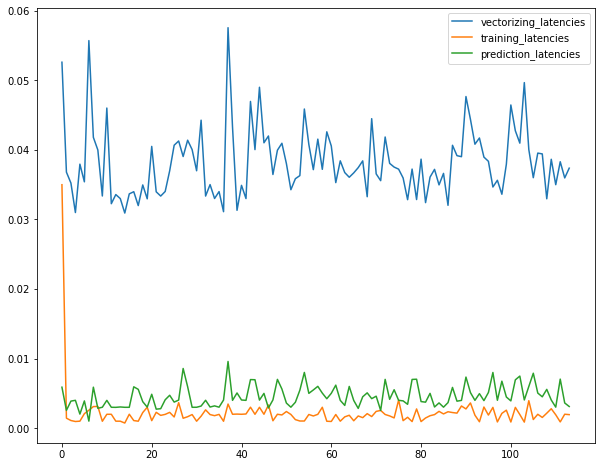

In [24]:
plot_latency_graphs(sgd_training_details_df)

In [25]:
def plot_accuracy_graphs(training_details_df):
    training_details_df[[
        'prediction_accuracies',
    ]].plot(figsize=(10, 8))
    plt.show();

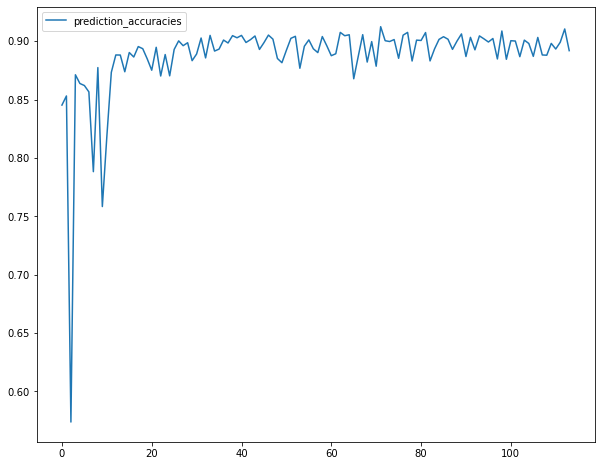

In [26]:
plot_accuracy_graphs(sgd_training_details_df)

In [27]:
y_pred = sgd_training_details['classifier'].predict(X_test)
accuracy_score(y_test, y_pred)

0.9020456608252461

In [29]:
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1: {f1_score(y_test, y_pred):.2f}')

Precision: 0.88
Recall: 0.45
F1: 0.60


In [30]:
# It should be noted that not all estimators have partial_fit() method.

In [31]:
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import BernoulliNB

In [32]:
partial_fit_clfs = {
    'SGD': SGDClassifier(),
    'Passive Aggressive': PassiveAggressiveClassifier(),
    'Perceptron': Perceptron(),
    'Bernoulli NB': BernoulliNB()
}

SGD
**************************************************


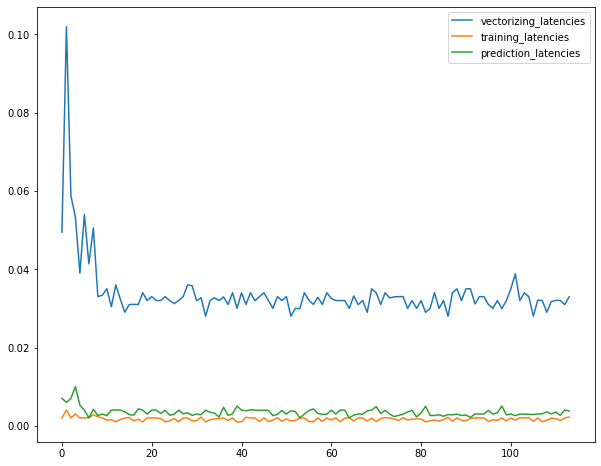

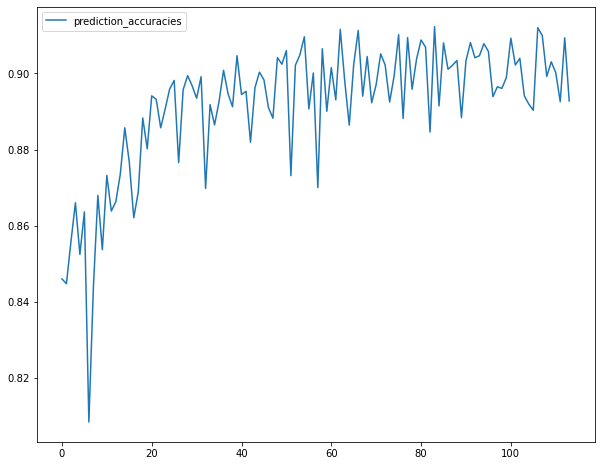

**************************************************
Passive Aggressive
**************************************************


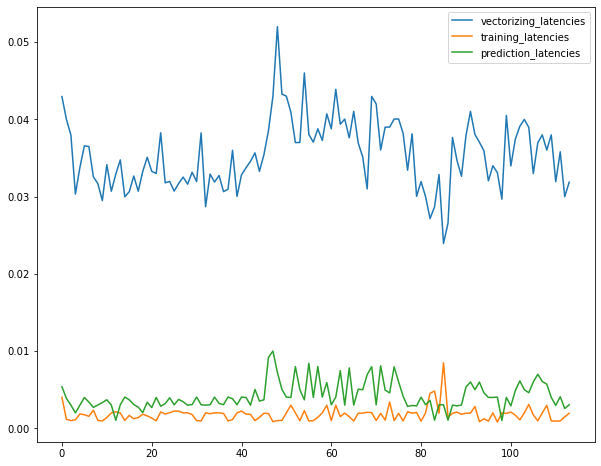

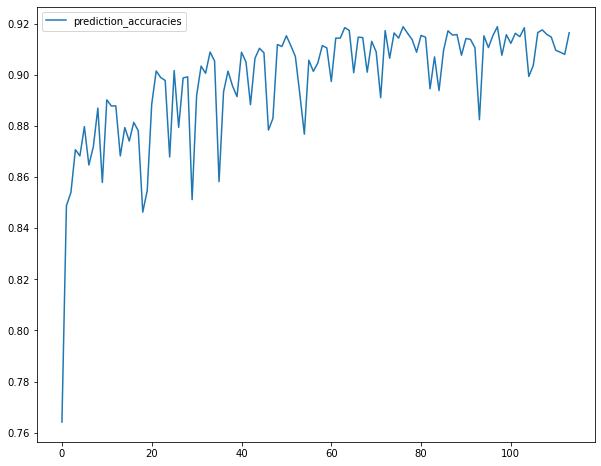

**************************************************
Perceptron
**************************************************


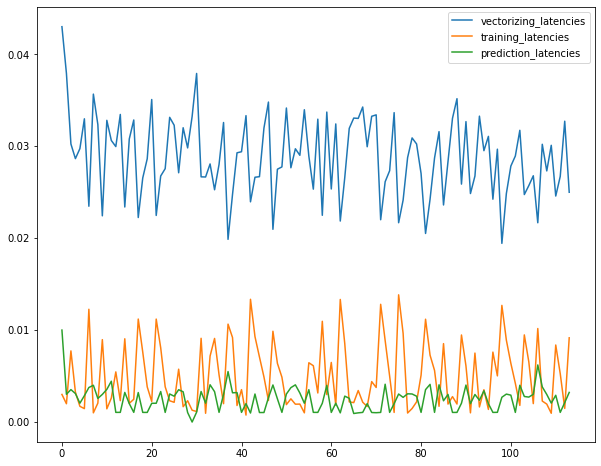

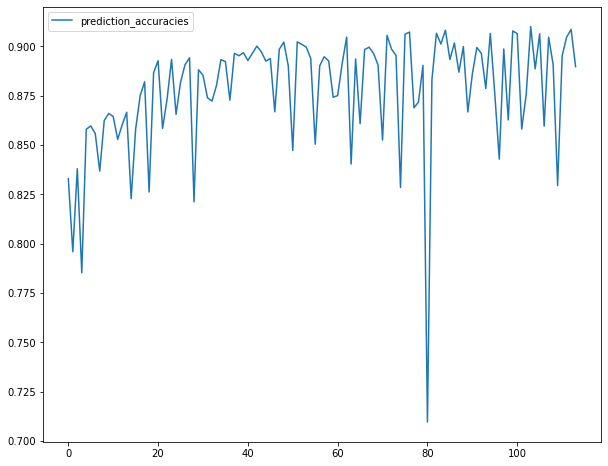

**************************************************
Bernoulli NB
**************************************************


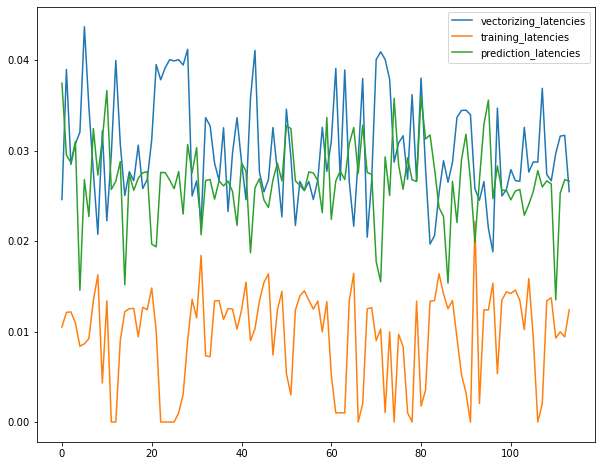

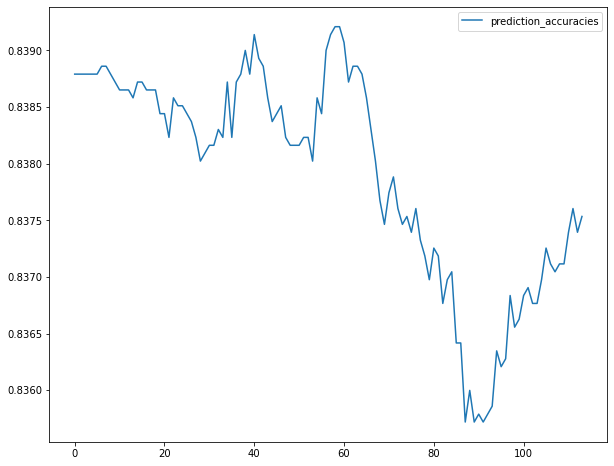

**************************************************


In [33]:
for clf_name, clf in partial_fit_clfs.items():

    print(clf_name)
    print('*' * 50)
    ooc_training_details = train_classifier(
        clf,
        X_train,
        y_train,
        X_test,
        y_test,
        BATCH_SIZE,
        CLASSES,
    )
    ooc_training_details_df = convert_to_df(ooc_training_details)
    plot_latency_graphs(ooc_training_details_df)
    plot_accuracy_graphs(ooc_training_details_df)
    print('*' * 50)
    sys.stdout.flush()

In [34]:
clf_stats = {}

for clf_name in partial_fit_clfs:
    y_pred = partial_fit_clfs[clf_name].predict(X_test)
    stats = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
    }
    clf_stats[clf_name] = stats

In [35]:
clf_stats

{'SGD': {'accuracy': 0.9128674160441248,
  'precision': 0.787222523010287,
  'recall': 0.6297098310957124,
  'f1': 0.699711260827719},
 'Passive Aggressive': {'accuracy': 0.9159393981707743,
  'precision': 0.7997829625610418,
  'recall': 0.6383715894326548,
  'f1': 0.710019267822736},
 'Perceptron': {'accuracy': 0.8924108077916637,
  'precision': 0.6478060046189377,
  'recall': 0.7288869640537029,
  'f1': 0.6859588343183208},
 'Bernoulli NB': {'accuracy': 0.8367660406339454,
  'precision': 0.48562933597621405,
  'recall': 0.21221307925508878,
  'f1': 0.2953586497890295}}

In [36]:
import pprint
pprint.pprint(clf_stats)

{'Bernoulli NB': {'accuracy': 0.8367660406339454,
                  'f1': 0.2953586497890295,
                  'precision': 0.48562933597621405,
                  'recall': 0.21221307925508878},
 'Passive Aggressive': {'accuracy': 0.9159393981707743,
                        'f1': 0.710019267822736,
                        'precision': 0.7997829625610418,
                        'recall': 0.6383715894326548},
 'Perceptron': {'accuracy': 0.8924108077916637,
                'f1': 0.6859588343183208,
                'precision': 0.6478060046189377,
                'recall': 0.7288869640537029},
 'SGD': {'accuracy': 0.9128674160441248,
         'f1': 0.699711260827719,
         'precision': 0.787222523010287,
         'recall': 0.6297098310957124}}


In [37]:
import gc
gc.collect()

33731